
Analyse sur 3 ans (de 2018-12-12 à 2021-12-12):

Metrics DataFrame:
          Ticker  expected_shortfall  Upside/Downside Capture Ratio  \
0  0P000073OA.TO            0.074586                       1.018028   
1  0P0000NFZ7.TO            0.011457                       0.968663   
2  0P00014EGI.TO            0.058534                       0.963755   
3  0P0000KOEE.TO            0.065464                       1.001478   

   Information Ratio Annual  Overall Score  Excess Returns  
0                  0.374863       0.453014        0.000109  
1                  0.049791       0.273881        0.000025  
2                  0.651457       0.586641        0.000146  
3                  0.685755       0.605731        0.000223  

Analyse sur 5 ans (de 2016-12-12 à 2021-12-12):

Metrics DataFrame:
          Ticker  expected_shortfall  Upside/Downside Capture Ratio  \
0  0P000073OA.TO            0.068417                       1.003333   
1  0P0000NFZ7.TO            0.032113                       

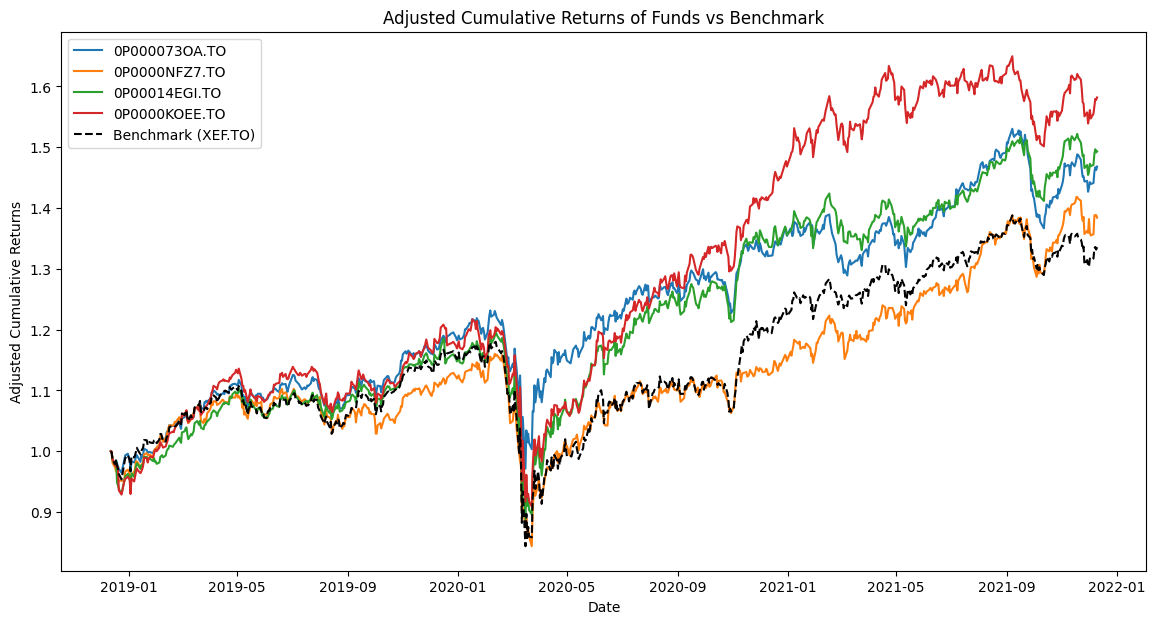

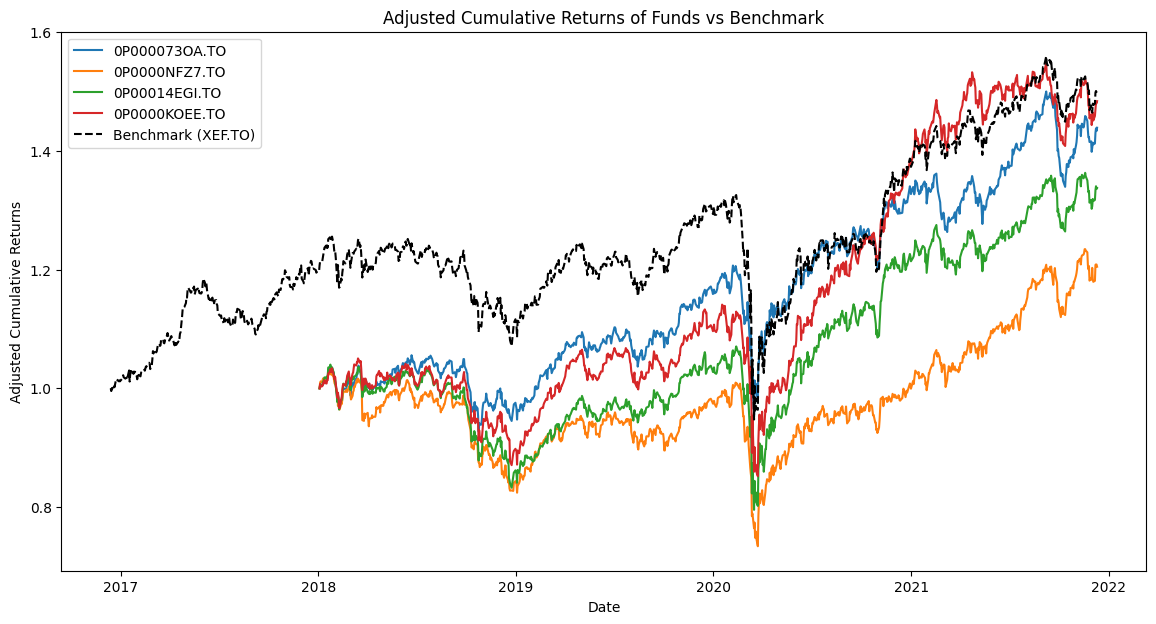

In [58]:
# Importation des modules nécessaires
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Définition des fonctions de base
def download_data(ticker, benchmark_ticker, start_date, end_date):
    """Télécharge les données historiques pour un ticker et un benchmark."""
    tickers = [ticker, benchmark_ticker] if ticker != benchmark_ticker else [ticker]
    data = yf.download(tickers, start=start_date, end=end_date, progress=False)
    
    if len(tickers) > 1:
        # Si plusieurs tickers sont demandés, vérifier la structure multi-index
        funds_prices = data['Adj Close'][ticker]
        benchmark_prices = data['Adj Close'][benchmark_ticker]
    else:
        # Si un seul ticker (donc ticker et benchmark_ticker sont identiques), accéder directement
        funds_prices = data['Adj Close']
        benchmark_prices = data['Adj Close']
    
    funds_prices.index = pd.to_datetime(funds_prices.index)
    benchmark_prices.index = pd.to_datetime(benchmark_prices.index)
    benchmark_returns = benchmark_prices.pct_change().dropna()
    return funds_prices, benchmark_returns


# Calcul des indicateurs
def calculate_metrics(prices, benchmark_returns, reinvestment_rate, confidence_level=0.05):
    """Calcule diverses métriques financières pour évaluer les performances."""
    # Calcul des rendements et des rendements excédentaires
    returns = prices.pct_change(fill_method=None).dropna()
    excess_returns = returns - benchmark_returns
    
    
    # Réinvestissement des dividendes
    adjusted_prices = adjust_for_dividends(prices, reinvestment_rate)
    adjusted_returns = adjusted_prices.pct_change(fill_method=None).dropna()
    adjusted_cum_returns = (1 + adjusted_returns).cumprod()

    # Calcul du drawdown maximal 
    # peak = adjusted_cum_returns.cummax()
    # drawdown = (adjusted_cum_returns - peak) / peak
    # max_drawdown = drawdown.min()

    # Upside/Downside Capture Ratio
    upside_returns = adjusted_returns[adjusted_returns > 0]
    downside_returns = adjusted_returns[adjusted_returns < 0]
    benchmark_upside_returns = benchmark_returns[benchmark_returns > 0]
    benchmark_downside_returns = benchmark_returns[benchmark_returns < 0]

    upside_capture_ratio = upside_returns.mean() / benchmark_upside_returns.mean() if benchmark_upside_returns.mean() != 0 else np.nan
    downside_capture_ratio = downside_returns.mean() / benchmark_downside_returns.mean() if benchmark_downside_returns.mean() != 0 else np.nan
    upside_downside_capture_ratio = upside_capture_ratio / downside_capture_ratio if downside_capture_ratio != 0 else np.nan
   

    # Calcul de la VaR
    var = -np.percentile(adjusted_returns, confidence_level * 100)

    #calul de l'expected shortfall
    expected_shortfall = (-adjusted_returns[adjusted_returns < var].mean())*100


    # Calcul du ratio d'information annuel
    annual_excess_returns = excess_returns.mean() * 252
    annual_std = excess_returns.std() * np.sqrt(252)
    information_ratio_annual = annual_excess_returns / annual_std

    overall_score = 0.50*(information_ratio_annual) + 0.25*(1-var) + 0.25*(expected_shortfall)
    return expected_shortfall, upside_downside_capture_ratio, information_ratio_annual, adjusted_cum_returns, excess_returns, overall_score


#A prendre au cas ou on a des dividendes non pris en compte sur Yahoo Finance
def adjust_for_dividends(prices, reinvestment_rate):
    """Ajuste les prix des fonds pour le réinvestissement des dividendes."""
    adjusted_prices = prices.copy()
    for year in range(adjusted_prices.index.year.min(), adjusted_prices.index.year.max() + 1):
        reinvestment_date = pd.Timestamp(year, 12, 30)
        if reinvestment_date in adjusted_prices.index:
            adjusted_prices.loc[reinvestment_date:] *= (1 + reinvestment_rate)
    return adjusted_prices

# Tracer les performances
def plot_performance(tickers, adjusted_cum_returns_dict, start_date, benchmark_cum_returns):
    """Trace les rendements cumulés ajustés pour les fonds depuis la start_date, incluant le benchmark."""
    plt.figure(figsize=(14, 7))
    for ticker in tickers:
        # Filtrez les rendements pour la période souhaitée
        filtered_returns = adjusted_cum_returns_dict[ticker][adjusted_cum_returns_dict[ticker].index >= start_date].dropna()
        # Réinitialisez le premier point de données à 1
        normalized_returns = filtered_returns / filtered_returns.iloc[0]
        plt.plot(normalized_returns.index, normalized_returns, label=ticker)

    # Faites la même chose pour le benchmark
    filtered_benchmark_returns = benchmark_cum_returns[benchmark_cum_returns.index >= start_date]
    normalized_benchmark_returns = filtered_benchmark_returns / filtered_benchmark_returns.iloc[0]
    plt.plot(normalized_benchmark_returns.index, normalized_benchmark_returns, label='Benchmark (XEF.TO)', linestyle='--', color='black')
    
    plt.title("Adjusted Cumulative Returns of Funds vs Benchmark")
    plt.xlabel("Date")
    plt.ylabel("Adjusted Cumulative Returns")
    plt.legend()
    plt.show()

def calculate_rolling_outperformance(funds_prices, benchmark_prices, window=12, total_years=7):
    """Calcule la surperformance glissante sur 12 mois par rapport au benchmark sur 7 ans."""
    # Calcul des rendements mensuels
    funds_returns = funds_prices.pct_change(fill_method=None).dropna()
    benchmark_returns = benchmark_prices.pct_change().dropna()

    # Alignement des séries temporelles
    aligned_funds_returns, aligned_benchmark_returns = funds_returns.align(benchmark_returns, join='inner')

    # Calcul des rendements cumulés sur 12 mois pour chaque mois de départ
    rolling_funds_returns = aligned_funds_returns.rolling(window=window).apply(lambda x: np.prod(1+x)-1)
    rolling_benchmark_returns = aligned_benchmark_returns.rolling(window=window).apply(lambda x: np.prod(1+x)-1)

    # Détermination de la surperformance
    outperformance = (rolling_funds_returns > rolling_benchmark_returns)

    # Calcul du pourcentage de surperformance
    outperformance_percentage = outperformance.sum() / outperformance.count() * 100

    return outperformance_percentage


#Boucle principale
def main():
    """Fonction principale pour exécuter l'analyse des performances sur 3 ans et 5 ans et calculer un score pondéré."""



    ########Utilisateur entre les données ici########
    tickers = ['0P000073OA.TO', '0P0000NFZ7.TO', '0P00014EGI.TO', '0P0000KOEE.TO']
    benchmark_ticker = 'XEF.TO'
    end_date = '2021-12-12'  # Date de fin commune
    end_date = datetime.strptime(end_date, '%Y-%m-%d')
    periods = [3, 5]  # Analyse sur 3 et 5 ans
    reinvestment_rates = {'0P000073OA.TO': 0.0, '0P0000NFZ7.TO': 0.0, '0P00014EGI.TO': 0.0, '0P0000KOEE.TO': 0.0}
    ########Fin de l'entrée des données###############


    benchmark_prices, _ = download_data(benchmark_ticker, benchmark_ticker, end_date - pd.DateOffset(years=5), end_date)
    benchmark_returns = benchmark_prices.pct_change().dropna()
    benchmark_cum_returns = (1 + benchmark_returns).cumprod()





    scores_by_ticker = {ticker: {} for ticker in tickers}

    for period in periods:
        start_date = end_date - pd.DateOffset(years=period)
        print(f"\nAnalyse sur {period} ans (de {start_date.date()} à {end_date.date()}):")
        
        metrics_list = []
        adjusted_cum_returns_dict = {}
        excess_returns_dict = {}

        for ticker in tickers:
            funds_prices, benchmark_returns = download_data(ticker, benchmark_ticker, start_date, end_date)
            expected_shortfall, upside_downside_capture_ratio, information_ratio_annual, adjusted_cum_returns, excess_returns, overall_score = calculate_metrics(funds_prices, benchmark_returns, reinvestment_rates[ticker])
            metrics_list.append({'Ticker': ticker, 'expected_shortfall': expected_shortfall, 'Upside/Downside Capture Ratio': upside_downside_capture_ratio, 'Information Ratio Annual': information_ratio_annual, 'Overall Score': overall_score, 'Excess Returns': excess_returns.mean()})  # Ajout de 'Overall Score' et 'Excess Returns' à la liste
            adjusted_cum_returns_dict[ticker] = adjusted_cum_returns
            excess_returns_dict[ticker] = excess_returns
            scores_by_ticker[ticker][period] = overall_score

        metrics_df = pd.DataFrame(metrics_list)
        print("\nMetrics DataFrame:")
        print(metrics_df)

    for ticker in tickers:
        funds_prices, benchmark_returns = download_data(ticker, benchmark_ticker, start_date, end_date)
        # Assurez-vous d'avoir les prix du benchmark sur la même période pour la comparaison
        benchmark_prices, _ = download_data(benchmark_ticker, benchmark_ticker, start_date, end_date)
        
        # Calcul de la surperformance glissante sur 12 mois sur 7 ans
        rolling_outperformance_percentage = calculate_rolling_outperformance(funds_prices, benchmark_prices, window=12, total_years=7)
        print(f"{ticker} Rolling 12-Month Outperformance over 7 Years: {rolling_outperformance_percentage}%")
    
    #Calcul du score pondéré
    weighted_scores = []
    for ticker, scores in scores_by_ticker.items():
        weighted_score = 0.70 * scores[5] + 0.30 * scores[3]  # 70% pour 5 ans, 30% pour 3 ans
        weighted_scores.append({'Ticker': ticker, 'Weighted Score': weighted_score})

    weighted_scores_df = pd.DataFrame(weighted_scores)
    print("\nWeighted Scores DataFrame:")
    print(weighted_scores_df)

    #calcul overall score normalisé
    weighted_scores_df['Mean Normalized Score'] = (weighted_scores_df['Weighted Score'] - weighted_scores_df['Weighted Score'].mean()) / (weighted_scores_df['Weighted Score'].max() - weighted_scores_df['Weighted Score'].min())
    print("\nNormalized Weighted Scores DataFrame:")
    print(weighted_scores_df)

    # Tracer les retours cumulés ajustés 
    three_year_start_date = end_date - pd.DateOffset(years=3)
    plot_performance(tickers, adjusted_cum_returns_dict, three_year_start_date, benchmark_cum_returns)

    five_year_start_date = end_date - pd.DateOffset(years=5)
    plot_performance(tickers, adjusted_cum_returns_dict, five_year_start_date, benchmark_cum_returns)

    #enregistrer les données
    metrics_df.to_csv('metrics.csv')
    

if __name__ == "__main__":
    main()


